In [278]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, SampleSet2D
from multiple_chains import MultipleChains
from tqdm import tqdm

In [279]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .90

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

# n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [280]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 2.03 and 5.97
The Credible Interval for y is between 0.52 and 3.48


In [281]:
# CHOLESKY SAMPLING

# samples_ch = SampleSet(n.cholesky_sample(20000))
# samples_ch.samples_plot(.95, kind='hist')

In [293]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 10
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 200

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

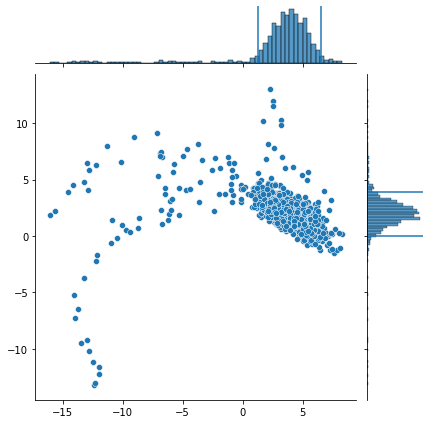

In [283]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

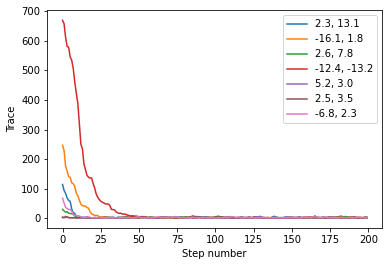

In [284]:
mh.traces_plot(every=1)

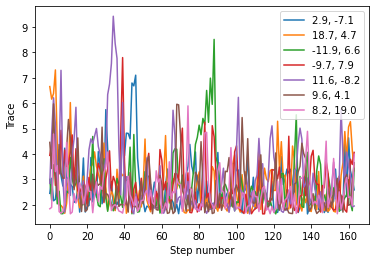

In [294]:
mh.trim_chains(mh.optimal_trimming)

mh.traces_plot(every=1)

In [286]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[1.12657946 1.14535618]
 [1.14535618 1.0740893 ]]
[1.024230384178499, 1.0109881680230748, 1.0406799769827033, 1.022722767547095, 1.017772023467783, 1.1050546182357, 1.0037419484805687]


In [287]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [295]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)
g.trim_chains(g.optimal_trimming)

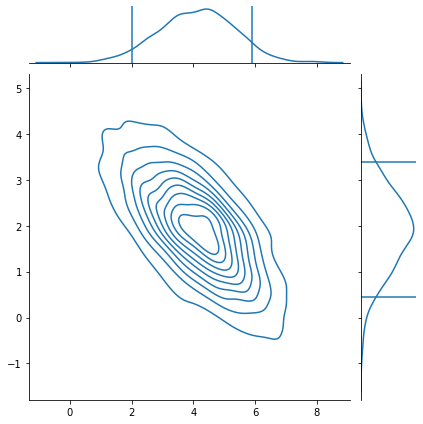

In [289]:
# g.traces_plot()
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [290]:
errors_mh_mean = []
errors_mh_cov = []
errors_g_mean = []
errors_g_cov = []

N_extensions = 10
x = np.geomspace(chain_length, 1000 * chain_length, dtype=int, num=50)
diffs = np.ediff1d(x, to_end=0)

for diff in tqdm(diffs):
    errors_mh_mean.append(np.average((mh.average_mean - n.mean)**2))
    errors_mh_cov.append(np.average((mh.average_covariance - n.cov)**2))
    errors_g_mean.append(np.average((g.average_mean - n.mean)**2))
    errors_g_cov.append(np.average((g.average_covariance - n.cov)**2))

    g.extend_chains(diff)
    mh.extend_chains(diff)

100%|██████████| 50/50 [01:07<00:00,  1.36s/it]


Text(0.5, 1.0, 'Errors')

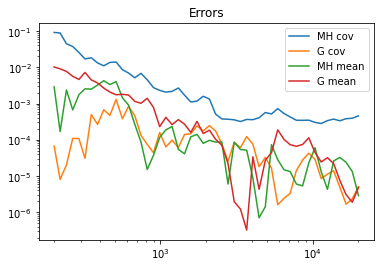

In [292]:
plt.loglog(x, errors_mh_cov, label = 'MH cov')
plt.loglog(x, errors_g_cov, label = 'G cov')
plt.loglog(x, errors_mh_mean, label = 'MH mean')
plt.loglog(x, errors_g_mean, label = 'G mean')

plt.legend()
plt.title('Errors')

In [291]:
diffs

array([  19,   22,   24,   26,   28,   32,   35,   38,   41,   46,   51,
         55,   61,   67,   73,   81,   89,   97,  107,  118,  129,  142,
        156,  171,  188,  206,  227,  249,  274,  301,  331,  363,  398,
        439,  481,  529,  580,  638,  701,  770,  846,  929, 1021, 1122,
       1231, 1354, 1486, 1633, 1795,    0])